In [1]:
import numpy as np
import pandas as pd
import copy

import gym
import hiive.mdptoolbox as mdptoolbox
from hiive.mdptoolbox.mdp import ValueIteration, PolicyIteration, QLearning
from gym import wrappers

import matplotlib.pyplot as plt
import seaborn

import time
import sys

# suppress warning
import warnings
warnings.filterwarnings('ignore')

# seed
np.random.seed(33)

<h3> Helper Functions </h3>

In [11]:
colors = {
    b'S': 'b',
    b'F': 'w',
    b'H': 'r',
    b'G': 'g'
}

directions = {
            0: '←',
            1: '↓',
            2: '→',
            3: '↑'
}

# plot lake function takes env, using openAI environment.
def plot_lake(env, policy=None, title='Frozen Lake', fig_size=8):
    squares = env.nrow
    fig = plt.figure(figsize=(fig_size, fig_size))
    ax = fig.add_subplot(111, xlim=(-.01, squares+0.01), ylim=(-.01, squares+0.01))
    plt.title(title, fontsize=16, weight='bold', y=1.01)
    for i in range(squares):
        for j in range(squares):
            y = squares - i - 1
            x = j
            p = plt.Rectangle([x, y], 1, 1, linewidth=1, edgecolor='k')
            p.set_facecolor(colors[env.desc[i,j]])
            ax.add_patch(p)
            
            if policy is not None:
                text = ax.text(x+0.5, y+0.5, directions[policy[i, j]],
                               horizontalalignment='center', size=25, verticalalignment='center',
                               color='k')
            
    plt.axis('off')
#     plt.savefig('./frozen/' + title + '.png', dpi=400)
    
#plot_lake(env, policy)

# code used only for small problems
# https://github.com/dxganta/solving_openai/blob/master/FrozenLake8x8/frozenLake8x8.py
def get_score(env, policy, printInfo=False, episodes=1000):
    misses = 0
    steps_list = []
    for episode in range(episodes):
        observation = env.reset()
        if type(observation) is tuple:
            observation = observation[0]
        steps=0
        while True:
#             print(observation)
# #             print(observation[0])
#             print(policy)
            action = policy[observation]
            observation, reward, terminated, truncated , info = env.step(action)
            steps+=1
            if terminated and reward == 1:
                # print('You have got the Frisbee after {} steps'.format(steps))
                steps_list.append(steps)
                break
            elif terminated and reward == 0:
                # print("You fell in a hole!")
                misses += 1
                break
    ave_steps = np.mean(steps_list)
    std_steps = np.std(steps_list)
    pct_fail  = (misses/episodes)* 100
    
    if (printInfo):
        print('----------------------------------------------')
        print('You took an average of {:.0f} steps to get the frisbee'.format(ave_steps))
        print('And you fell in the hole {:.2f} % of the times'.format(pct_fail))
        print('----------------------------------------------')
  
    return ave_steps, std_steps, pct_fail


def vi_plots(data_df,xAttr,xList):
    #steps
    x = xList
    y = []
    for g in xList:
        y.append(data_df.loc[data_df[xAttr] == g]['average_steps'].mean())
    sigma = []
    for g in xList:
        sigma.append(data_df.loc[data_df[xAttr] == g]['average_steps'].std())
    max = []
    for g in xList:
        max.append(data_df.loc[data_df[xAttr] == g]['average_steps'].max())


    #time
    time = []
    for g in xList:
        time.append(data_df.loc[data_df[xAttr] == g]['time'].mean())
    t_sigma = []
    for g in xList:
        t_sigma.append(data_df.loc[data_df[xAttr] == g]['time'].std())
    t_max = []
    for g in xList:
        t_max.append(data_df.loc[data_df[xAttr] == g]['time'].max())


    #reward
    reward = []
    for g in xList:
        reward.append(data_df.loc[data_df[xAttr] == g]['reward'].mean())
    r_sigma = []
    for g in xList:
        r_sigma.append(data_df.loc[data_df[xAttr] == g]['reward'].std())
    r_max = []
    for g in xList:
        r_max.append(data_df.loc[data_df[xAttr] == g]['reward'].max())


    #success
    success = []
    for g in xList:
        success.append(data_df.loc[data_df[xAttr] == g]['success_pct'].mean())
    s_sigma = []
    for g in xList:
        s_sigma.append(data_df.loc[data_df[xAttr] == g]['success_pct'].std())
    s_max = []
    for g in xList:
        s_max.append(data_df.loc[data_df[xAttr] == g]['success_pct'].max())

        
    #iteration
    iterations = []
    for g in xList:
        iterations.append(data_df.loc[data_df[xAttr] == g]['iterations'].mean())
    i_sigma = []
    for g in xList:
        i_sigma.append(data_df.loc[data_df[xAttr] == g]['iterations'].std())
    i_max = []
    for g in xList:
        i_max.append(data_df.loc[data_df[xAttr] == g]['iterations'].max())
        

    fig = plt.figure(figsize=(6,4))
    plt.plot(x, y, 'o-', label='Average Steps')
    plt.plot(x, max, 'o--', label='Max Steps')
    plt.fill_between(x, np.array(y)-np.array(sigma), np.array(y)+np.array(sigma), color='b', alpha=0.1)

    plt.title('Average/Max Steps Taken vs. Gamma')
    plt.xlabel(xAttr)
    plt.legend(loc='best')
    plt.ylabel('Steps')
    plt.grid(True)
    plt.show()


    fig = plt.figure(figsize=(6,4))
    plt.plot(x, reward, 'o-', label='Average Reward')
    plt.plot(x, r_max, 'o--', label='Max Reward')
    plt.fill_between(x, np.array(reward)-np.array(r_sigma), np.array(reward)+np.array(r_sigma), color='b', alpha=0.1)

    plt.title('Average/Max Reward vs. Gamma')
    plt.xlabel(xAttr)
    plt.legend(loc='best')
    plt.ylabel('Reward')
    plt.grid(True)
    plt.show()

    fig = plt.figure(figsize=(6,4))
    plt.plot(x, time, 'o-', label='Average time')
    plt.plot(x, t_max, 'o--', label='Max time')
    plt.fill_between(x, np.array(time)-np.array(t_sigma), np.array(time)+np.array(t_sigma), color='b', alpha=0.1)

    plt.title('Average/Max Time Taken vs. Gamma')
    plt.xlabel(xAttr)
    plt.legend(loc='best')
    plt.ylabel('Time')
    plt.grid(True)
    plt.show()

    fig = plt.figure(figsize=(6,4))
    plt.plot(x, success, 'o-', label='Average Success PCT')
    plt.plot(x, s_max, 'o--', label='Max Success PCT')
    plt.fill_between(x, np.array(success)-np.array(s_sigma), np.array(success)+np.array(s_sigma), color='b', alpha=0.1)

    plt.title('Average/Max Success PCT vs. Gamma')
    plt.xlabel(xAttr)
    plt.legend(loc='best')
    plt.ylabel('Success PCT')
    plt.grid(True)
    plt.show()
    
    fig = plt.figure(figsize=(6,4))
    plt.plot(x, iterations, 'o-', label='Average Iterations')
    plt.plot(x, i_max, 'o--', label='Max Iterations')
    plt.fill_between(x, np.array(iterations)-np.array(i_sigma), np.array(iterations)+np.array(i_sigma), color='b', alpha=0.1)

    plt.title('Average/Max Iterations vs. Gamma')
    plt.xlabel(xAttr)
    plt.legend(loc='best')
    plt.ylabel('Iterations')
    plt.grid(True)
    plt.show()


def pi_plots(data_df,xAttr,xList):
    #steps
    x = xList
    y = data_df['average_steps']
    sigma = data_df['steps_stddev']

    #time
    time = data_df['time']
    
    #reward
    reward = data_df['reward']

    #success
    success = data_df['success_pct']
    
    #iterations
    iterations = data_df['iterations']



    fig = plt.figure(figsize=(6,4))
    plt.plot(x, y, 'o-', label='Steps')
    plt.fill_between(x, np.array(y)-np.array(sigma), np.array(y)+np.array(sigma), color='b', alpha=0.1)

    plt.title('Steps Taken vs. Gamma')
    plt.xlabel(xAttr)
    plt.ylabel('Steps')
    plt.grid(True)
    plt.show()


    fig = plt.figure(figsize=(6,4))
    plt.plot(x, reward, 'o-', label='Reward')
    plt.title('Reward vs. Gamma')
    plt.xlabel(xAttr)
    plt.ylabel('Reward')
    plt.grid(True)
    plt.show()

    fig = plt.figure(figsize=(6,4))
    plt.plot(x, time, 'o-', label='Time')
    plt.title('Time Taken vs. Gamma')
    plt.xlabel(xAttr)
    plt.ylabel('Time')
    plt.grid(True)
    plt.show()

    fig = plt.figure(figsize=(6,4))
    plt.plot(x, success, 'o-', label='Success PCT')
    plt.title('Success PCT vs. Gamma')
    plt.xlabel(xAttr)
    plt.ylabel('Success PCT')
    plt.grid(True)
    plt.show()
    
    fig = plt.figure(figsize=(6,4))
    plt.plot(x, iterations, 'o-', label='Iterations')
    plt.title('iterations vs. Gamma')
    plt.xlabel(xAttr)
    plt.ylabel('iterations')
    plt.grid(True)
    plt.show()

def make_time_array(run_stats, variables):
    cumulative_sum = 0
    times = []
    output_dict = {v:[] for v in variables}
    output_dict["times"] = times
    for result in run_stats:
        times.append(result["Time"])
        for v in result:
            if v in variables:
                output_dict[v].append(result[v])
    return output_dict

def plot_simple_data(x_var, y_var, x_label, y_label, title, figure_size=(4,3)):
    plt.rcParams["figure.figsize"] = figure_size
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.plot(x_var, y_var, 'o-')
    plt.grid(True)
    plt.show()

    
# directions = {
#             0: '←',
#             1: '↓',
#             2: '→',
#             3: '↑'
# }

colors = {
    b'S': 'b',
    b'F': 'w',
    b'H': 'r',
    b'G': 'g'
}
def fancy_visual(value_func,policy_str, grid=4, env=None, title=None, fig_size_l=11, fig_size_w=9, save=False):
    if title == None:
        title= 'Heatmap with policy, value Function and directions'
    f, ax = plt.subplots(figsize=(fig_size_l, fig_size_w))
    cmap =  seaborn.light_palette("seagreen", as_cmap=True) #seaborn.diverging_palette(220, 10, as_cmap=True)
    reshaped=np.reshape(value_func,(grid,grid))
    seaborn.heatmap(reshaped, cmap=cmap, vmax=1.1,
                square=True,
                linewidths=.5, cbar_kws={"shrink": .5}, ax=ax, annot=True, fmt=".3f")
    counter=0
    for j in range(0, grid):
        for i in range(0, grid):
#             print(j)
#             print(i)
#             print(env.desc[j,i])
            if env:
                x = grid - i - 1
                y = j
#                 print(colors[env.desc[j,i]])
                if colors[env.desc[j,i]] != 'w':
                    p = plt.Rectangle([i, j], 1, 1, linewidth=1, edgecolor='k')
                    p.set_facecolor(colors[env.desc[j,i]])
                    ax.add_patch(p)
            if policy_str[counter]==1:
                plt.text(i+0.5, j+0.7, u'\u2193', fontsize=12)
            elif policy_str[counter]==3:
                plt.text(i+0.5, j+0.7, u'\u2191', fontsize=12)
            elif policy_str[counter]==0:
                plt.text(i+0.5, j+0.7, u'\u2190', fontsize=12)
            else:
                plt.text(i+0.5, j+0.7, u'\u2192', fontsize=12)
            counter=counter+1

    plt.title(title)
    if save:
        plt.savefig('hmaplarge.png')


<h3> Environments </h3>

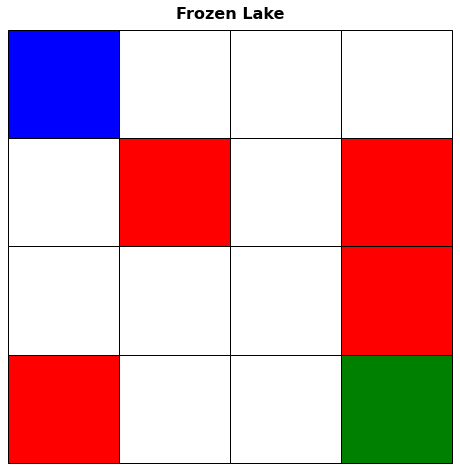

In [54]:
# Setup 4x4
# env4 = gym.make('FrozenLake-v1', is_slippery=True).unwrapped #FrozenLake8x8-v1
env4 = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True).unwrapped

env4.max_episode_steps=250

# Create transition and reward matrices from OpenAI P matrix
rows = env4.nrow
cols = env4.ncol
FL4_T = np.zeros((4, rows*cols, rows*cols))
FL4_R = np.zeros((4, rows*cols, rows*cols))

old_state = np.inf

for square in env4.P:
    for action in env4.P[square]:
        for i in range(len(env4.P[square][action])):
            new_state = env4.P[square][action][i][1]
            if new_state == old_state:
                FL4_T[action][square][env4.P[square][action][i][1]] = FL4_T[action][square][old_state] + env4.P[square][action][i][0]
                FL4_R[action][square][env4.P[square][action][i][1]] = FL4_R[action][square][old_state] + env4.P[square][action][i][2]
            else:
                FL4_T[action][square][env4.P[square][action][i][1]] = env4.P[square][action][i][0]
                FL4_R[action][square][env4.P[square][action][i][1]] = env4.P[square][action][i][2]
            old_state = env4.P[square][action][i][1]
            
#print(T)
#print(R)
plot_lake(env4)

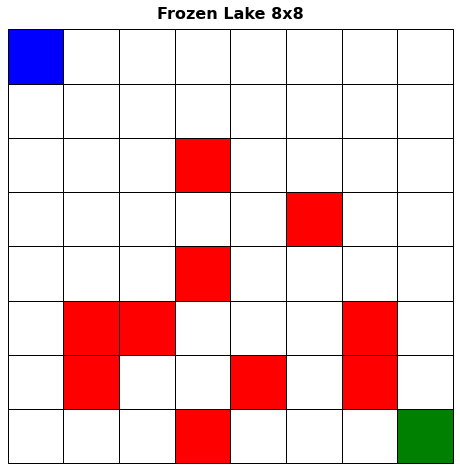

In [99]:
# Setup 4x4
env8 = gym.make('FrozenLake8x8-v1', is_slippery=True).unwrapped #FrozenLake8x8-v1

# env8.max_episode_steps=250

# Create transition and reward matrices from OpenAI P matrix
rows = env8.nrow
cols = env8.ncol
FL8_T = np.zeros((4, rows*cols, rows*cols))
FL8_R = np.zeros((4, rows*cols, rows*cols))

old_state = np.inf

for square in env8.P:
    for action in env8.P[square]:
        for i in range(len(env8.P[square][action])):
            new_state = env8.P[square][action][i][1]
            if new_state == old_state:
                FL8_T[action][square][env8.P[square][action][i][1]] = FL8_T[action][square][old_state] + env8.P[square][action][i][0]
                FL8_R[action][square][env8.P[square][action][i][1]] = FL8_R[action][square][old_state] + env8.P[square][action][i][2]
            else:
                FL8_T[action][square][env8.P[square][action][i][1]] = env8.P[square][action][i][0]
                FL8_R[action][square][env8.P[square][action][i][1]] = env8.P[square][action][i][2]
            old_state = env8.P[square][action][i][1]
            
#print(T)
#print(R)
plot_lake(env8, policy=None, title='Frozen Lake 8x8', fig_size=8)

In [100]:
FL8_R_N = copy.deepcopy(FL8_R)
where_0 = np.where(FL8_R_N == 0)
where_1 = np.where(FL8_R_N == 1)

FL8_R_N[where_0] = -0.01
FL8_R_N[where_1] = 100

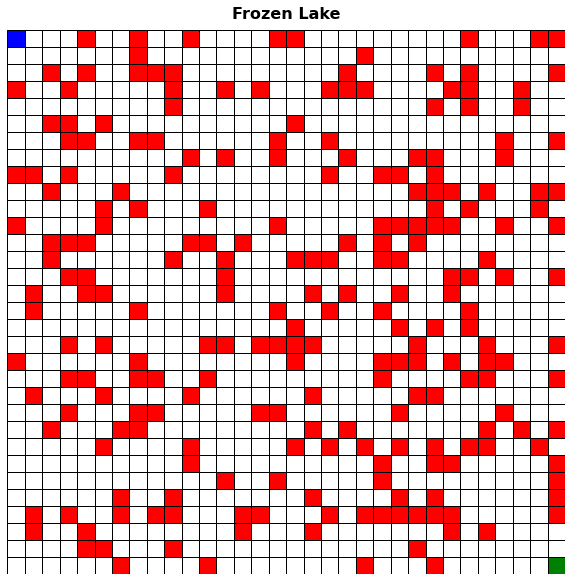

In [57]:
#16 states.
import hiive.mdptoolbox.example
from gym.envs.toy_text.frozen_lake import generate_random_map
np.random.seed(33)
env32_2 = gym.make('FrozenLake-v1', desc=generate_random_map(size=32)).unwrapped

# Create transition and reward matrices from OpenAI P matrix
rows = env32_2.nrow
cols = env32_2.ncol
FL322_T = np.zeros((4, rows*cols, rows*cols))
FL322_R = np.zeros((4, rows*cols, rows*cols))

old_state = np.inf

for square in env32_2.P:
    for action in env32_2.P[square]:
        for i in range(len(env32_2.P[square][action])):
            new_state = env32_2.P[square][action][i][1]
            if new_state == old_state:
                FL322_T[action][square][env32_2.P[square][action][i][1]] = FL322_T[action][square][old_state] + env32_2.P[square][action][i][0]
                FL322_R[action][square][env32_2.P[square][action][i][1]] = FL322_R[action][square][old_state] + env32_2.P[square][action][i][2]
            else:
                FL322_T[action][square][env32_2.P[square][action][i][1]] = env32_2.P[square][action][i][0]
                FL322_R[action][square][env32_2.P[square][action][i][1]] = env32_2.P[square][action][i][2]
            old_state = env32_2.P[square][action][i][1]
            
            
plot_lake(env32_2, fig_size=10)

In [16]:
FL322_R_N = copy.deepcopy(FL322_R)
where_0 = np.where(FL322_R_N == 0)
where_1 = np.where(FL322_R_N == 1)

FL322_R_N[where_0] = -1
FL322_R_N[where_1] = 1000

In [17]:
# from gym.envs.toy_text.frozen_lake import generate_random_map
# env16 = gym.make('FrozenLake-v1', desc=generate_random_map(size=32))

import hiive.mdptoolbox.example
from gym.envs.toy_text.frozen_lake import generate_random_map
random_map = generate_random_map(size=32, p=0.98)
FL32_T, FL32_R = hiive.mdptoolbox.example.openai("FrozenLake-v1", desc=random_map)

print(FL32_T.shape)
print(FL32_R.shape)



(4, 1024, 1024)
(1024, 4)


<h3>Q Learning Experiment</h3>

In [85]:
def qLearning(t, r, gammas, alphas, alpha_decays=[0.99], epsilon_decays=[0.99], n_iterations=[10000000], showResults=False, policy_stat=True, p_size=4):
    # create data structure to save off
    columns = ['gamma', 'alpha', 'alpha_decay', 'epsilon_decay', 'iterations', 'time', 'reward', 'average_steps', 'steps_stddev', 'success_pct', 'policy', 'mean_rewards', 'max_rewards', 'error']
    numTests = len(gammas)*len(alphas)*len(alpha_decays)*len(epsilon_decays)*len(n_iterations)
    data = pd.DataFrame(0.0, index=np.arange(numTests), columns=columns)
    env_p = env4
    if p_size ==8:
        env_p = env8
    print('Gamma,\tAlpha,\tTime,\tIter,\tReward')
    print(80*'_')
    
    testNum = 0
    for g in gammas:
        for a in alphas:
            for a_decay in alpha_decays:
                for e_decay in epsilon_decays:
                    for n in n_iterations:
                        print('Test Num %d/%d' %(testNum+1, numTests))
                        print('Gamma: %.2f,\tAlpha: %.2f,\tAlpha Decay:%.3f,\tEpsilon Decay:%.3f,\tIterations:%d' 
                             %(g, a, a_decay, e_decay, n))
                        
                        test = QLearning(t, r, gamma=g, alpha=a, alpha_decay=a_decay, epsilon_decay=e_decay, n_iter=n)
                        
                        runs  = test.run()
                        time  = runs[-1]['Time']
                        iters = runs[-1]['Iteration']
                        maxR  = runs[-1]['Max V']
                        
                        max_rewards, mean_rewards, errors = [], [], []
                        for run in runs:
                            max_rewards.append(run['Max V'])
                            mean_rewards.append(run['Mean V'])
                            errors.append(run['Error'])
                        
                        policy = np.array(test.policy)
                        policy = policy.reshape(p_size,p_size)
                        
                        data['gamma'][testNum]         = g
                        data['alpha'][testNum]         = a
                        data['alpha_decay'][testNum]   = a_decay
                        data['epsilon_decay'][testNum] = e_decay
                        data['time'][testNum]          = time
                        data['iterations'][testNum]    = iters
                        data['reward'][testNum]        = maxR
                        data['mean_rewards'][testNum]  = {tuple(mean_rewards)}
                        data['max_rewards'][testNum]   = {tuple(max_rewards)}
                        data['error'][testNum]         = {tuple(errors)}
                        data['policy'][testNum]        = {test.policy}
                        
                        print('%.2f,\t%.2f,\t%.2f,\t%d,\t%f' % (g, a, time, iters, maxR))
                        
                        if showResults:
                            title = 'FrozenLake_QL_' + str(rows) + 'x' + str(cols) + '_g' + str(g) + '_a' + str(a) + '_adecay' + str(a_decay) + '_edecay' + str(e_decay) + '_iter' + str(n)
                            plot_lake(env_p, policy, title)
                        
                        testNum = testNum + 1
            
    # See differences in policy
    if policy_stat:
        policies = data['policy']

        for i,p in enumerate(policies):
            pol = list(p)[0]
            steps, steps_stddev, failures = get_score(env_p, pol, showResults)
            data['average_steps'][i] = steps
            data['steps_stddev'][i]  = steps_stddev
            data['success_pct'][i]   = 100-failures      
        
    # replace all NaN's
    data.fillna(0, inplace=True)
    data.head()
        
    return data

In [80]:
%%time

#  def __init__(self, transitions, reward, gamma,
#                  alpha=0.1, alpha_decay=0.99, alpha_min=0.001,
#                  epsilon=1.0, epsilon_min=0.1, epsilon_decay=0.99,
#                  n_iter=10000, skip_check=False, iter_callback=None,
#                  run_stat_frequency=None):
        
fl4_q = QLearning(FL4_T, FL4_R, gamma=.999, alpha=0.07, alpha_decay=0.999, epsilon_decay=0.9999, n_iter=1e5)
fl4_q.run()
p_policy = fl4_q.policy

fl4_q_curated_results = make_time_array(fl4_q.run_stats, ["Mean V", "Max V", "Iteration", "Error", "Reward"])
p_max_v= max(fl4_q_curated_results["Mean V"])
V_Max_4 =[]
V_Max_V4 =[]
V_Max_4.append(p_max_v)
p_nvar= 0
for i in range(400):
    fl4_q.run()
    n_policy = fl4_q.policy
    fl4_q_curated_results = make_time_array(fl4_q.run_stats, ["Mean V", "Max V", "Iteration", "Error", "Reward"])
    n_max_v= max(fl4_q_curated_results["Mean V"])
    V_Max_4.append(n_max_v)
    c_m_V = max(fl8_q_curated_results["Max V"])
    V_Max_V4.append(c_m_V)
    fl4_q.alpha = 0.07 # your prefered alpha
    fl4_q.epsilon = 1
    
    if i > 30:
        n_var= np.var(V_Max_4[:-10])
        diff = n_var-p_nvar
        print(diff)
        print(c_m_V)
        p_nvar=n_var
        if (diff < 0.0001):
            l_check +=1
        else:
            l_check = 0
            
        if (l_check > 10) and (c_m_V > 0.99):
            print('converged')
            break
  


0.0003860181938347778
0.9810826977412339
1.0085524810985423e-05
0.9810826977412339
9.56758790009491e-06
0.9810826977412339
1.2819276868766534e-05
0.9810826977412339
1.810396532735478e-05
0.9810826977412339
2.2374841807019463e-05
0.9810826977412339
2.3551789504856584e-05
0.9810826977412339
2.9330523915667515e-05
0.9810826977412339
3.0548467249735356e-05
0.9810826977412339
2.9912858396295228e-05
0.9810826977412339
2.6945172014704246e-05
0.9810826977412339
3.117734472779781e-05
0.9810826977412339
3.365658739484703e-05
0.9810826977412339
3.260021034752838e-05
0.9810826977412339
3.3607295950482496e-05
0.9810826977412339
3.5776314295744e-05
0.9810826977412339
3.152905380257153e-05
0.9810826977412339
3.274573074892452e-05
0.9810826977412339
3.0084402142645022e-05
0.9810826977412339
2.56659571188717e-05
0.9810826977412339
2.5202840943598604e-05
0.9810826977412339
2.5539889319869794e-05
0.9810826977412339
2.4007636401834486e-05
0.9810826977412339
2.1535467553753136e-05
0.9810826977412339
2.7134

8.333921869833547e-05
0.9810826977412339
8.105821733433646e-05
0.9810826977412339
7.9334721454518e-05
0.9810826977412339
7.644952372596464e-05
0.9810826977412339
7.383799350495907e-05
0.9810826977412339
6.875421794858352e-05
0.9810826977412339
6.835633429620736e-05
0.9810826977412339
7.087278740767686e-05
0.9810826977412339
6.932668543057144e-05
0.9810826977412339
6.916152682363494e-05
0.9810826977412339
6.839949092087017e-05
0.9810826977412339
6.708229652564388e-05
0.9810826977412339
6.504622364070928e-05
0.9810826977412339
6.669426936064052e-05
0.9810826977412339
6.651468325896345e-05
0.9810826977412339
6.528197306934769e-05
0.9810826977412339
6.492325228862894e-05
0.9810826977412339
6.59678364382417e-05
0.9810826977412339
6.416217502395322e-05
0.9810826977412339
6.372932013860161e-05
0.9810826977412339
6.534863529089954e-05
0.9810826977412339
6.393832045459291e-05
0.9810826977412339
6.387646225605725e-05
0.9810826977412339
6.524502714295305e-05
0.9810826977412339
6.391295066440067e-

In [81]:
V_Max_4

[0.009449044391232082,
 0.014115667131165998,
 0.01858840964066341,
 0.022801867734958757,
 0.02760720339541768,
 0.03235783158350886,
 0.035664849570861204,
 0.03834264088226762,
 0.0431087058236881,
 0.04550801527384425,
 0.04904301459476233,
 0.05170875965309142,
 0.054579555782535066,
 0.05547128852264345,
 0.05984924249099509,
 0.06237327744018199,
 0.06567789993719998,
 0.06805919216820301,
 0.06966769357075048,
 0.06953908035664187,
 0.0698904088111499,
 0.07188499225140696,
 0.07349649360415658,
 0.07380840508861344,
 0.07499950438940295,
 0.07802612074596953,
 0.0820651419388578,
 0.08571019690122461,
 0.08808388029154111,
 0.09242077427865589,
 0.09495628597811556,
 0.09672688957018286,
 0.09743430871600411,
 0.10113532222606525,
 0.10415078821387652,
 0.10571371415148628,
 0.1080997525671951,
 0.11097975808878595,
 0.11112829659421854,
 0.11352301469594114,
 0.1141872307674251,
 0.11387648504772091,
 0.11528440070763912,
 0.11705399141338758,
 0.11787855990499951,
 0.1181310

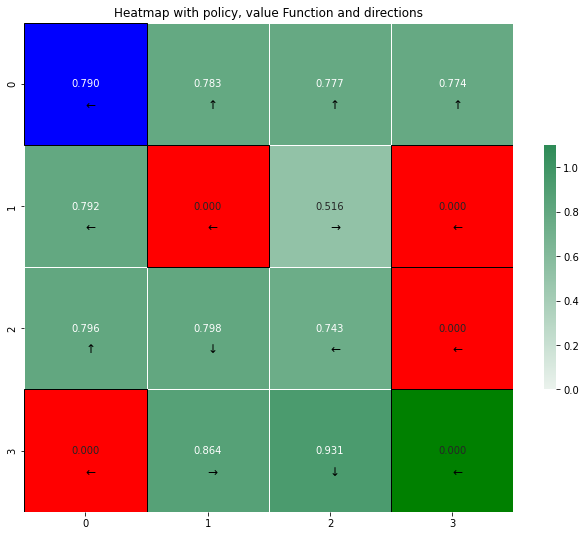

In [82]:
fancy_visual(fl4_q.V,fl4_q.policy,grid=4, env=env4) 

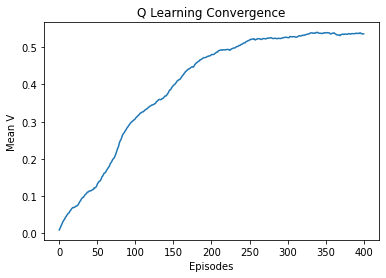

In [83]:
plt.plot(range(0,len(V_Max_4), 1),V_Max_4 )
plt.xticks()

plt.ylabel('Mean V') #set the label for y axis
plt.xlabel('Episodes') #set the label for x-axis
plt.title("Q Learning Convergence") #set the title of the graph
plt.show() #display the graph

In [121]:
%%time

#  def __init__(self, transitions, reward, gamma,
#                  alpha=0.1, alpha_decay=0.99, alpha_min=0.001,
#                  epsilon=1.0, epsilon_min=0.1, epsilon_decay=0.99,
#                  n_iter=10000, skip_check=False, iter_callback=None,
#                  run_stat_frequency=None):
        

fl8_q = QLearning(FL8_T, FL8_R, gamma=.999, alpha=0.07, alpha_decay=0.999, epsilon_decay=0.9999, n_iter=1e5)
fl8_q.run()
p_policy = fl8_q.policy

fl8_q_curated_results = make_time_array(fl8_q.run_stats, ["Mean V", "Max V", "Iteration", "Error", "Reward"])
p_max_v= max(fl8_q_curated_results["Mean V"])
c_m_V = max(fl8_q_curated_results["Max V"])
V_Max_8k =[]
V_Max_8x8 =[]
V_Max_8k.append(p_max_v)
V_Max_8x8.append(c_m_V)
p_nvar= 0
l_check = 0
for i in range(900):
    fl8_q.run()
    n_policy = fl8_q.policy
    fl8_q_curated_results = make_time_array(fl8_q.run_stats, ["Mean V", "Max V", "Iteration", "Error", "Reward"])
    n_max_v= max(fl8_q_curated_results["Mean V"])
    c_m_V = max(fl8_q_curated_results["Max V"])
    V_Max_8k.append(n_max_v)
    V_Max_8x8.append(c_m_V)
    fl8_q.alpha = 0.07 # your prefered alpha
    fl8_q.epsilon = 1
    
    if i > 100:
        n_var= np.var(V_Max_8k[:-10])
        diff = n_var-p_nvar
        print(diff)
        print(c_m_V)
        p_nvar=n_var
        if (diff < 0.0001):
            l_check +=1
        else:
            l_check = 0
            
        if (l_check > 10) and (c_m_V > 0.99):
            print('converged')
            break
            
            

nan
0.5016472699479877
nan
0.5013300050719525
nan
0.49732101429982833
nan
0.4819747830473055
nan
0.4819747830473055
nan
0.48009195777952846
nan
0.48113077382467323
nan
0.4832392046825474
nan
0.4841006143573125
nan
0.5369203881198206
nan
0.5820750222140075
nan
0.6170220485094919
nan
0.6478456051805694
nan
0.6729198925792883
nan
0.6954316813918003
nan
0.7124161722755517
nan
0.7285495435701185
nan
0.7462467768654615
nan
0.7535631392921512
nan
0.7613967888886692
nan
0.7710758784867361
nan
0.7760936510776335
nan
0.7809245695285136
nan
0.787385950629602
nan
0.8060454479485414
nan
0.8203450552534529
nan
0.8188124471279414
nan
0.8206951044922272
nan
0.8266508827787458
nan
0.8308747545568324
nan
0.836371359411475
nan
0.8383437100557264
nan
0.8432724745060176
nan
0.8466877267290677
nan
0.8473389681513169
nan
0.8480222290514059
nan
0.8505142930319601
nan
0.8544454028197085
nan
0.8639842402730058
nan
0.8660255668331105
nan
0.8647326543056689
nan
0.8651645442926834
nan
0.865558306186525
nan
0.86689

nan
0.9812882515485309
nan
0.9811138083275054
nan
0.9808528248895582
nan
0.9808358182162695
nan
0.9806951582339772
nan
0.9804870324608828
nan
0.9809903765206197
nan
0.9808761627015122
nan
0.9810086618598373
nan
0.9813497759038462
nan
0.9810911499167017
nan
0.9812129120087076
nan
0.9827117057396904
nan
0.9825870601215836
nan
0.9820770711844087
nan
0.9819614015454957
nan
0.9821798025570403
nan
0.9819532033437256
nan
0.982134374763534
nan
0.982391700758293
nan
0.9822575350667113
nan
0.9819011600799687
nan
0.9819441103359468
nan
0.981846353179275
nan
0.9819559542705159
nan
0.9817361345793093
nan
0.981895100155732
nan
0.9818497395062331
nan
0.9815993623135579
nan
0.9815855823451913
nan
0.981503900488111
nan
0.9814735869085606
nan
0.9820044769064998
nan
0.9821465612896283
nan
0.9818844887689694
nan
0.9819658970654206
nan
0.981724625350063
nan
0.9817765519516369
nan
0.9818623757880593
nan
0.9820088508030791
nan
0.9814313880934664
nan
0.9815082739491173
nan
0.9817375908908366
nan
0.98187345367

nan
0.9824421017840208
nan
0.9821071515355705
nan
0.9816256220756926
nan
0.9818411052074139
nan
0.9813859176643526
nan
0.9818145853176361
nan
0.982568685815202
nan
0.982400603149932
nan
0.9816212262386369
nan
0.9813582442109079
nan
0.981389907973338
nan
0.9816240759709921
nan
0.9818554911264012
nan
0.9813316215392074
nan
0.9809958584446016
nan
0.9813157771869413
nan
0.982403495515526
nan
0.9823344858972499
nan
0.9822213267517107
nan
0.9817471771213613
nan
0.981293683345416
nan
0.9812428942192558
nan
0.9808278874432932
nan
0.9808272795558586
nan
0.9807791549816977
nan
0.9812265731915452
nan
0.9811612920365924
nan
0.9811149368071332
nan
0.9815076394067405
nan
0.9813788887261284
nan
0.9812515047329732
nan
0.981443628892374
nan
0.9812210363056614
nan
0.9808286482470089
nan
0.98157044158569
nan
0.9811525684943195
nan
0.9811979338690343
nan
0.9807838888959746
nan
0.9803787788881476
nan
0.9804749765075601
nan
0.9807665099747734
nan
0.9810072953675254
nan
0.9807231318122357
nan
0.9813143959501

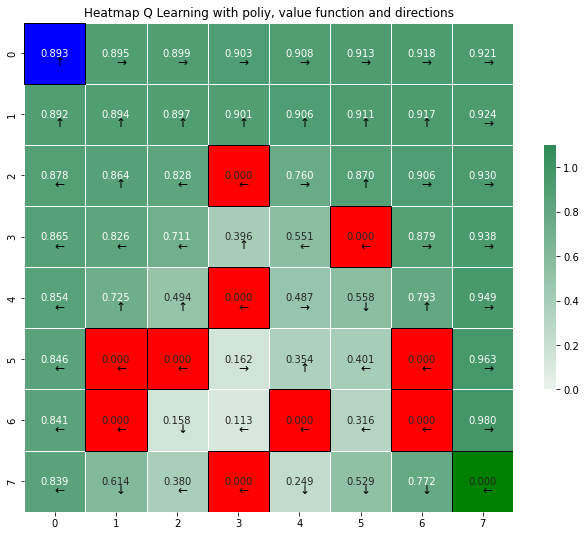

In [122]:
fancy_visual(fl8_q.V,fl8_q.policy,grid=8, env=env8, title='Heatmap Q Learning with poliy, value function and directions') 

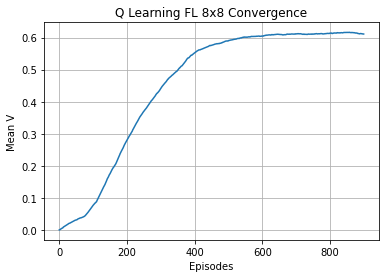

In [123]:
plt.plot(range(0,len(V_Max_8k), 1),V_Max_8k, '-' )
plt.xticks()

plt.ylabel('Mean V') #set the label for y axis
plt.xlabel('Episodes') #set the label for x-axis
plt.title("Q Learning FL 8x8 Convergence") #set the title of the graph
plt.grid()
plt.show() #display the graph

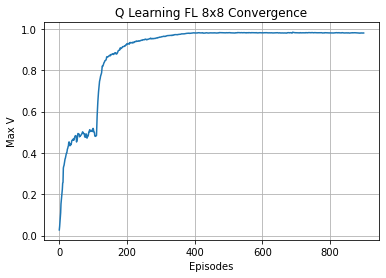

In [124]:
plt.plot(range(0,len(V_Max_8x8), 1),V_Max_8x8, '-' )
plt.xticks()

plt.ylabel('Max V') #set the label for y axis
plt.xlabel('Episodes') #set the label for x-axis
plt.title("Q Learning FL 8x8 Convergence") #set the title of the graph
plt.grid()
plt.show() #display the graph

<h3>Negative 8x8 FL</h3>

In [110]:
%%time

#  def __init__(self, transitions, reward, gamma,
#                  alpha=0.1, alpha_decay=0.99, alpha_min=0.001,
#                  epsilon=1.0, epsilon_min=0.1, epsilon_decay=0.99,
#                  n_iter=10000, skip_check=False, iter_callback=None,
#                  run_stat_frequency=None):
        

fl8_q_N = QLearning(FL8_T, FL8_R_N, gamma=.999, alpha=0.07, alpha_decay=0.999, epsilon_decay=0.9999, n_iter=1e5)
fl8_q_N.run()
p_policy = fl8_q_N.policy

fl8_q_curated_results_N = make_time_array(fl8_q_N.run_stats, ["Mean V", "Max V", "Iteration", "Error", "Reward"])
p_max_v= max(fl8_q_curated_results_N["Mean V"])
c_m_V = max(fl8_q_curated_results_N["Max V"])
V_Max_8_N =[]
V_Max_8x8_N =[]
V_Max_8_N.append(p_max_v)
V_Max_8x8_N.append(c_m_V)
p_nvar= 0
l_check = 0
for i in range(900):
    fl8_q_N.run()
    n_policy = fl8_q_N.policy
    fl8_q_curated_results_N = make_time_array(fl8_q_N.run_stats, ["Mean V", "Max V", "Iteration", "Error", "Reward"])
    n_max_v= max(fl8_q_curated_results_N["Mean V"])
    c_m_V = max(fl8_q_curated_results_N["Max V"])
    V_Max_8_N.append(n_max_v)
    V_Max_8x8_N.append(c_m_V)
    fl8_q_N.alpha = 0.07 # your prefered alpha
    fl8_q_N.epsilon = 1
    
    if i > 100:
        n_var= np.var(V_Max_8_N[:-10])
        diff = n_var-p_nvar
        print(diff)
        print(c_m_V)
        p_nvar=n_var
        if (diff < 0.0001):
            l_check +=1
        else:
            l_check = 0
            
        if (l_check > 10) and (c_m_V > 99):
            print('converged')
            break
            
            

4.625382539263449
58.62409257972912
0.1617072852023025
63.01149599431715
0.1686472981297209
66.12582907981468
0.1773420663164771
69.17501438339343
0.18197109793202504
71.06344662216138
0.19070639576093473
73.25357367461129
0.19948950061864057
74.1421561413793
0.20632570836078923
75.24557455460462
0.21449642555432558
76.58685389915722
0.2304587230994377
77.4176980107281
0.2528465016942718
77.85254580368971
0.2760944922013895
78.5913969975139
0.29782406877864886
79.55802637926598
0.32784866165217874
80.12636533617153
0.3480401835408582
80.86669654075769
0.37723866623367375
81.11574471488098
0.4003595338766406
81.13455580716204
0.42100793947728476
81.67415454791228
0.44663628635688113
82.20509136853944
0.4681875550895036
82.81112272899205
0.48907222840681186
83.16444543056593
0.5156560912565045
83.26813666663928
0.5373655965876605
83.5325772777715
0.5586933444039897
83.51559494852533
0.586111467989296
84.06781191531803
0.6071004281080032
84.13256871536167
0.6318164404243891
84.52937408317

1.0715695612923923
90.90032134018642
1.0621059376557014
90.89509049599788
1.0465982782953347
90.91409436853914
1.038574855509978
90.89943364191875
1.034978298120052
90.91657331706271
1.0203602864180539
90.92590038826293
1.0139548277895187
90.90312720164694
1.00820920288578
90.90012672288616
0.9945034599278983
90.84861059237772
0.9969817890208219
90.96255065211052
0.9808206781962099
90.95907161213017
0.9651717804476334
90.94420259299355
0.956704661256083
90.96160624839172
0.9546538525343635
90.89777331598091
0.9504700222501583
90.83948704513331
0.9373567893288737
90.78469226658578
0.9349423700469401
90.6955047171293
0.9172150333336617
90.71508850415782
0.9027579141390447
90.74799817041104
0.8977365290132866
90.76098902806876
0.8921988283744327
90.75559064744242
0.8913069301923429
90.79676534855076
0.8816111260426851
90.76111819910598
0.879024422988266
90.73340218224452
0.8682747139776552
90.72908581000169
0.8572480127142512
90.7215698404333
0.8536611499085325
90.70832814050914
0.8389539

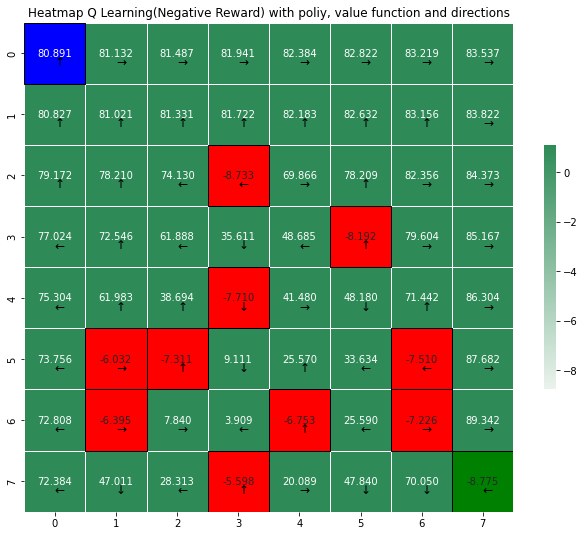

In [111]:
fancy_visual(fl8_q_N.V,fl8_q_N.policy,grid=8, env=env8, title='Heatmap Q Learning(Negative Reward) with poliy, value function and directions') 

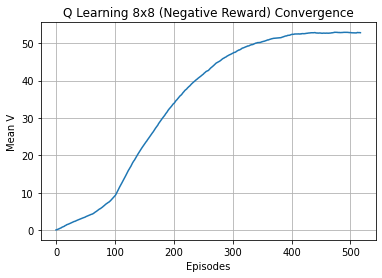

In [126]:
plt.plot(range(0,len(V_Max_8_N), 1),V_Max_8_N )
plt.xticks()

plt.ylabel('Mean V') #set the label for y axis
plt.xlabel('Episodes') #set the label for x-axis
plt.title("Q Learning 8x8 (Negative Reward) Convergence") #set the title of the graph
plt.grid()
plt.show() #display the graph

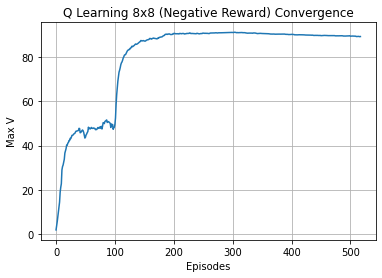

In [125]:
plt.plot(range(0,len(V_Max_8x8_N), 1),V_Max_8x8_N )
plt.xticks()

plt.ylabel('Max V') #set the label for y axis
plt.xlabel('Episodes') #set the label for x-axis
plt.title("Q Learning 8x8 (Negative Reward) Convergence") #set the title of the graph
plt.grid()
plt.show() #display the graph

In [87]:
gammas         = [ 0.999]
alphas         = [ 0.1, 0.2]
alpha_decays   = [0.9, 0.999]
epsilon_decays = [0.9, 0.99, 0.9999]
iterations     = [1e6]


ql_data_fl4  = qLearning(FL4_T, FL4_R, gammas, alphas, alpha_decays=alpha_decays, epsilon_decays=epsilon_decays, n_iterations=iterations, showResults=False, policy_stat=False, p_size=4)
ql_data_fl8  = qLearning(FL8_T, FL8_R, gammas, alphas, alpha_decays=alpha_decays, epsilon_decays=epsilon_decays, n_iterations=iterations, showResults=False, policy_stat=False, p_size=8)
ql_data_fl32  = qLearning(FL322_T, FL322_R, gammas, alphas, alpha_decays=alpha_decays, epsilon_decays=epsilon_decays, n_iterations=iterations, showResults=False, policy_stat=False, p_size=32)


Gamma,	Alpha,	Time,	Iter,	Reward
________________________________________________________________________________
Test Num 1/12
Gamma: 1.00,	Alpha: 0.10,	Alpha Decay:0.900,	Epsilon Decay:0.900,	Iterations:1000000
1.00,	0.10,	35.43,	1000000,	0.543601
Test Num 2/12
Gamma: 1.00,	Alpha: 0.10,	Alpha Decay:0.900,	Epsilon Decay:0.990,	Iterations:1000000
1.00,	0.10,	35.97,	1000000,	0.406143
Test Num 3/12
Gamma: 1.00,	Alpha: 0.10,	Alpha Decay:0.900,	Epsilon Decay:1.000,	Iterations:1000000
1.00,	0.10,	35.84,	1000000,	0.357205
Test Num 4/12
Gamma: 1.00,	Alpha: 0.10,	Alpha Decay:0.999,	Epsilon Decay:0.900,	Iterations:1000000
1.00,	0.10,	35.52,	1000000,	0.548548
Test Num 5/12
Gamma: 1.00,	Alpha: 0.10,	Alpha Decay:0.999,	Epsilon Decay:0.990,	Iterations:1000000
1.00,	0.10,	35.26,	1000000,	0.328590
Test Num 6/12
Gamma: 1.00,	Alpha: 0.10,	Alpha Decay:0.999,	Epsilon Decay:1.000,	Iterations:1000000
1.00,	0.10,	35.73,	1000000,	0.515333
Test Num 7/12
Gamma: 1.00,	Alpha: 0.20,	Alpha Decay:0.900,	Epsilon Dec

In [107]:
interest = ['gamma', 'alpha', 'alpha_decay', 'epsilon_decay', 'iterations' ,'time', 'reward']
df1 = ql_data_fl4[interest]
df1.columns = ['gamma', 'alpha', 'alpha_decay', 'epsilon_decay', 'iterations', 'time_4x4', 'reward_4x4']

interest2 = ['time',  'reward']
df2 = ql_data_fl8[interest2]
df2.columns = ['time_8x8', 'reward_8x8']

df3 = ql_data_fl32[interest2]
df3.columns = ['time_32x32', 'reward_32x32']


In [108]:
result = pd.concat([df1, df2, df3], axis=1)
result

cm = seaborn.light_palette('green', as_cmap='True')
s = result.style.background_gradient(cmap=cm)
s

,gamma,alpha,alpha_decay,epsilon_decay,iterations,time_4x4,reward_4x4,time_8x8,reward_8x8,time_32x32,reward_32x32
0,0.999000,0.100000,0.900000,0.900000,1000000.000000,35.430772,0.543601,56.972064,0.139047,303.556234,0.004977
1,0.999000,0.100000,0.900000,0.990000,1000000.000000,35.972464,0.406143,57.790847,0.117840,301.492222,0.008878
2,0.999000,0.100000,0.900000,0.999900,1000000.000000,35.837157,0.357205,58.682399,0.113437,308.065809,0.017729
3,0.999000,0.100000,0.999000,0.900000,1000000.000000,35.523549,0.548548,55.850007,0.128115,297.410989,0.004968
4,0.999000,0.100000,0.999000,0.990000,1000000.000000,35.262305,0.328590,59.687322,0.133656,306.104073,0.013784
5,0.999000,0.100000,0.999000,0.999900,1000000.000000,35.731146,0.515333,57.276548,0.106236,313.227828,0.040163
6,0.999000,0.200000,0.900000,0.900000,1000000.000000,36.494775,0.477832,58.752144,0.169019,297.968948,0.009920
7,0.999000,0.200000,0.900000,0.990000,1000000.000000,38.427004,0.351649,56.043292,0.116478,305.764967,0.012858
8,0.999000,0.200000,0.900000,0.999900,1000000.000000,42.015003,0.601429,57.560834,0.184308,287.231815,0.017675
9,0.999000,0.200000,0.999000,0.900000,1000000.000000,39.087004,0.494958,58.120050,0.156883,294.250819,0.005970
